# MAGMA experimnetations

## Artificial data : Different HP + Common grid

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
import warnings

plt.style.use("bmh")
sys.path.append("../src/")
warnings.filterwarnings("ignore")

from kernels import ExponentiatedQuadraticKernel, GaussianKernel
from MAGMA import MAGMA

### Data

In [2]:
N = 10
M = 5

t0 = 10
tN = 20

common_T = np.linspace(t0, tN, N)
print(common_T.shape)

(10,)


In [3]:
a = np.random.uniform(-2, 2)
b = np.random.uniform(0, 10)

m0 = a * common_T + b
m0_function = lambda t : a * t + b
print(m0.shape)

(10,)


In [4]:
theta0 = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))])
print(theta0)

[32.3326229   5.40349203]


In [5]:
K_theta0 = ExponentiatedQuadraticKernel.compute_all(theta0, common_T)
print(K_theta0.shape)

(10, 10)


In [6]:
mu0 = np.random.multivariate_normal(m0, K_theta0)
print(mu0.shape)

(10,)


In [7]:
Theta = np.array([np.random.uniform(1, np.exp(5), size=M), np.random.uniform(1, np.exp(2), size=M)]).T
Sigma = np.random.uniform(0, 1, size=M)

print(Theta)
print(Sigma)

[[ 80.47809024   5.07545023]
 [ 21.04363314   5.1463533 ]
 [138.17891266   4.18082566]
 [ 67.03348316   3.62863719]
 [ 91.28344366   6.32655399]]
[0.01483779 0.353053   0.51967888 0.35631101 0.98424745]


In [8]:
Y = np.zeros((M, N))
for i in range(M):
    C_Theta = ExponentiatedQuadraticKernel.compute_all(Theta[i], common_T)
    Psi_Theta_Sigma = C_Theta + Sigma[i] * np.identity(N)
    Yi = np.random.multivariate_normal(mu0, Psi_Theta_Sigma)
    Y[i] = Yi
print(Y.shape)

(5, 10)


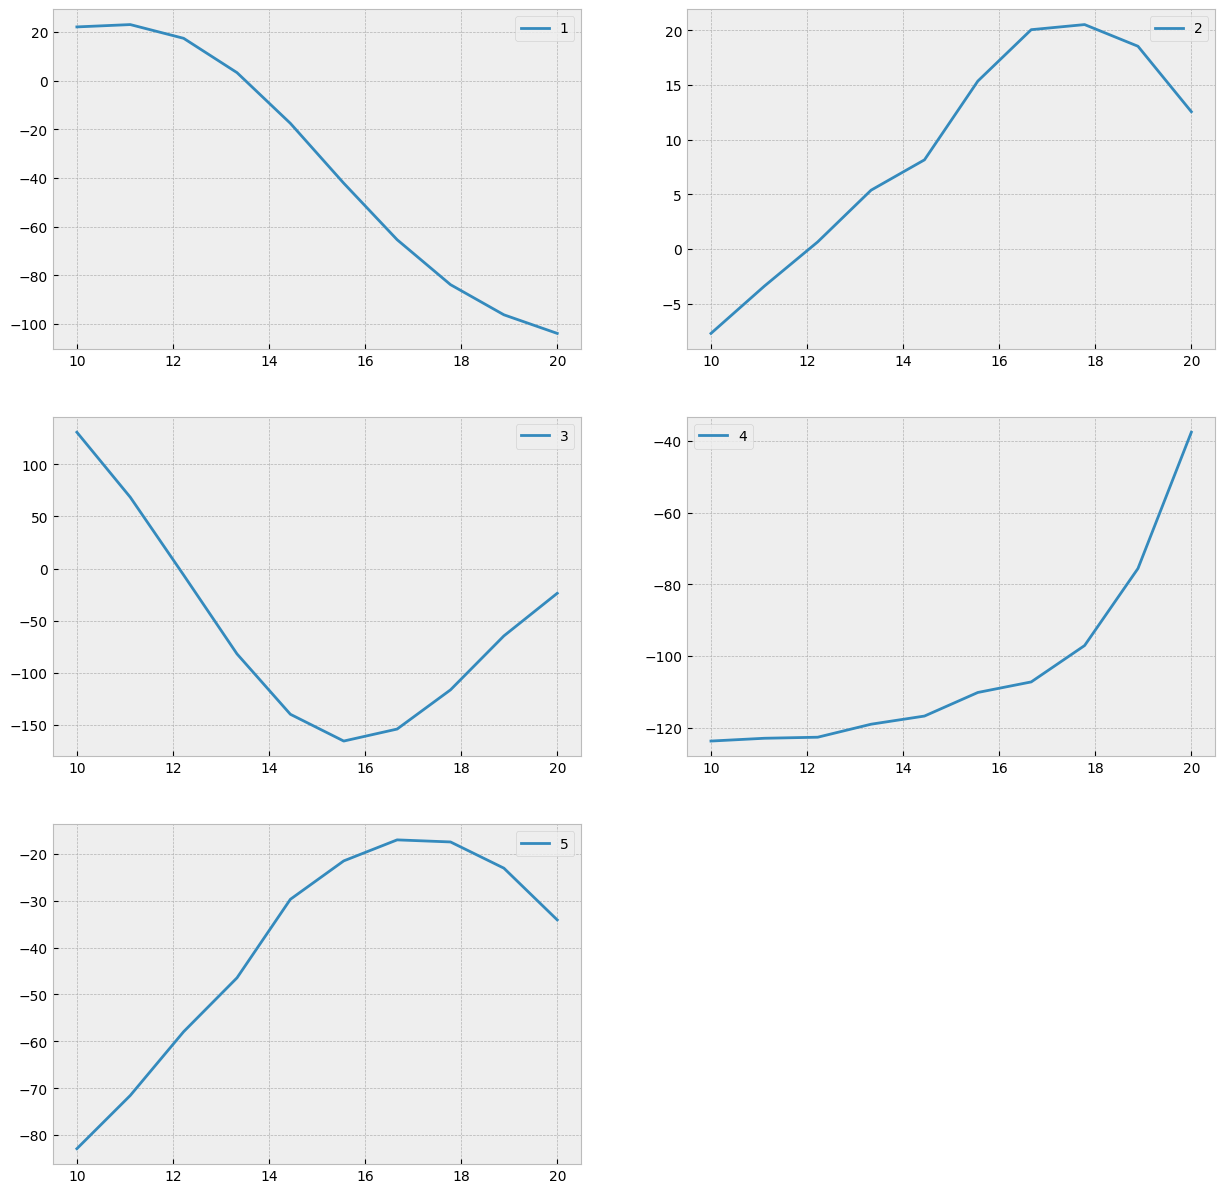

In [9]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(common_T, Y[i - 1], label=f"{i}")
    plt.legend()
plt.show()

### Model

#### Training

In [10]:
model = MAGMA(
    T=None,
    Y=Y,
    common_T=common_T,
    m0=np.zeros(len(m0)),
    m0_function=m0_function,
    theta0=np.array([np.random.uniform(0.99,1.01), np.random.uniform(0.99,1.01)]),
    Theta=np.array([np.random.uniform(0.99,1.01, size=M), np.random.uniform(0.99,1.01, size=M)]).T,
    Sigma=np.random.uniform(0.49, 0.51, size=M),
    common_hp_flag=False,
    common_grid_flag=True,
    save_history_flag=True,
    scipy_optimize_display=True,
    kernel_k=ExponentiatedQuadraticKernel,
    kernel_c=ExponentiatedQuadraticKernel,
)

In [11]:
model.fit(max_iterations=1, eps=1e-2)

MAGMA Training:   0%|          | 0/1 [00:00<?, ?it/s]

theta0
Theta & Sigma 0
Theta & Sigma 1
Theta & Sigma 2
Theta & Sigma 3


MAGMA Training: 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

Theta & Sigma 4


In [12]:
model.scipy_optimize_display = False
model.fit(max_iterations=49, eps=1e-2)

MAGMA Training: 100%|██████████| 49/49 [00:06<00:00,  7.39it/s]


In [13]:
history = model.history
len(history)

51

In [14]:
LL_theta0 = []
LL_Theta_Sigma = []

for epoch_history in history[1:]:
    LL_theta0.append(epoch_history["LL_theta0"])
    LL_Theta_Sigma.append(epoch_history["LL_Theta_Sigma"])

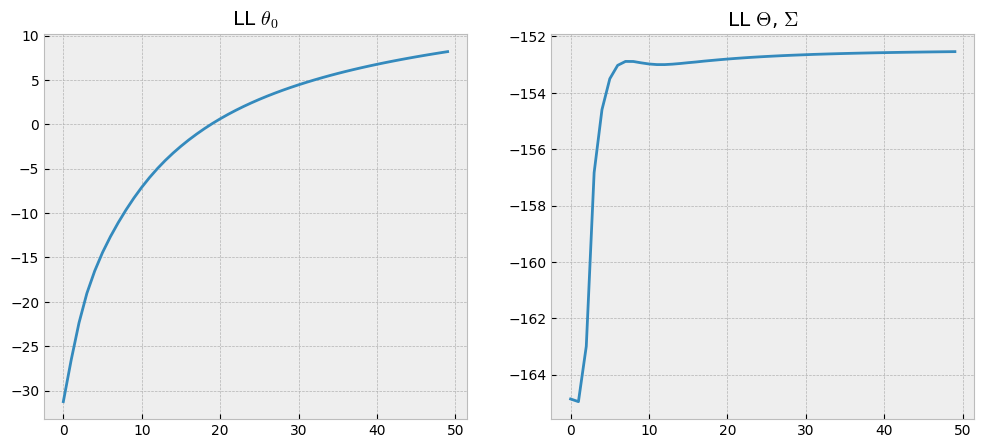

In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(LL_theta0)
plt.title("LL $\\theta_0$")
plt.subplot(1, 2, 2)
plt.plot(LL_Theta_Sigma)
plt.title("LL $\Theta$, $\Sigma$")
plt.show()

In [16]:
Sigma_estim = []
for epoch_history in history:
    Sigma_estim.append(epoch_history["Sigma"])
Sigma_estim = np.array(Sigma_estim)
print(model.Sigma)
print(Sigma)

[0.09039231 0.81409598 0.77796114 1.03150882 1.22746205]
[0.01483779 0.353053   0.51967888 0.35631101 0.98424745]


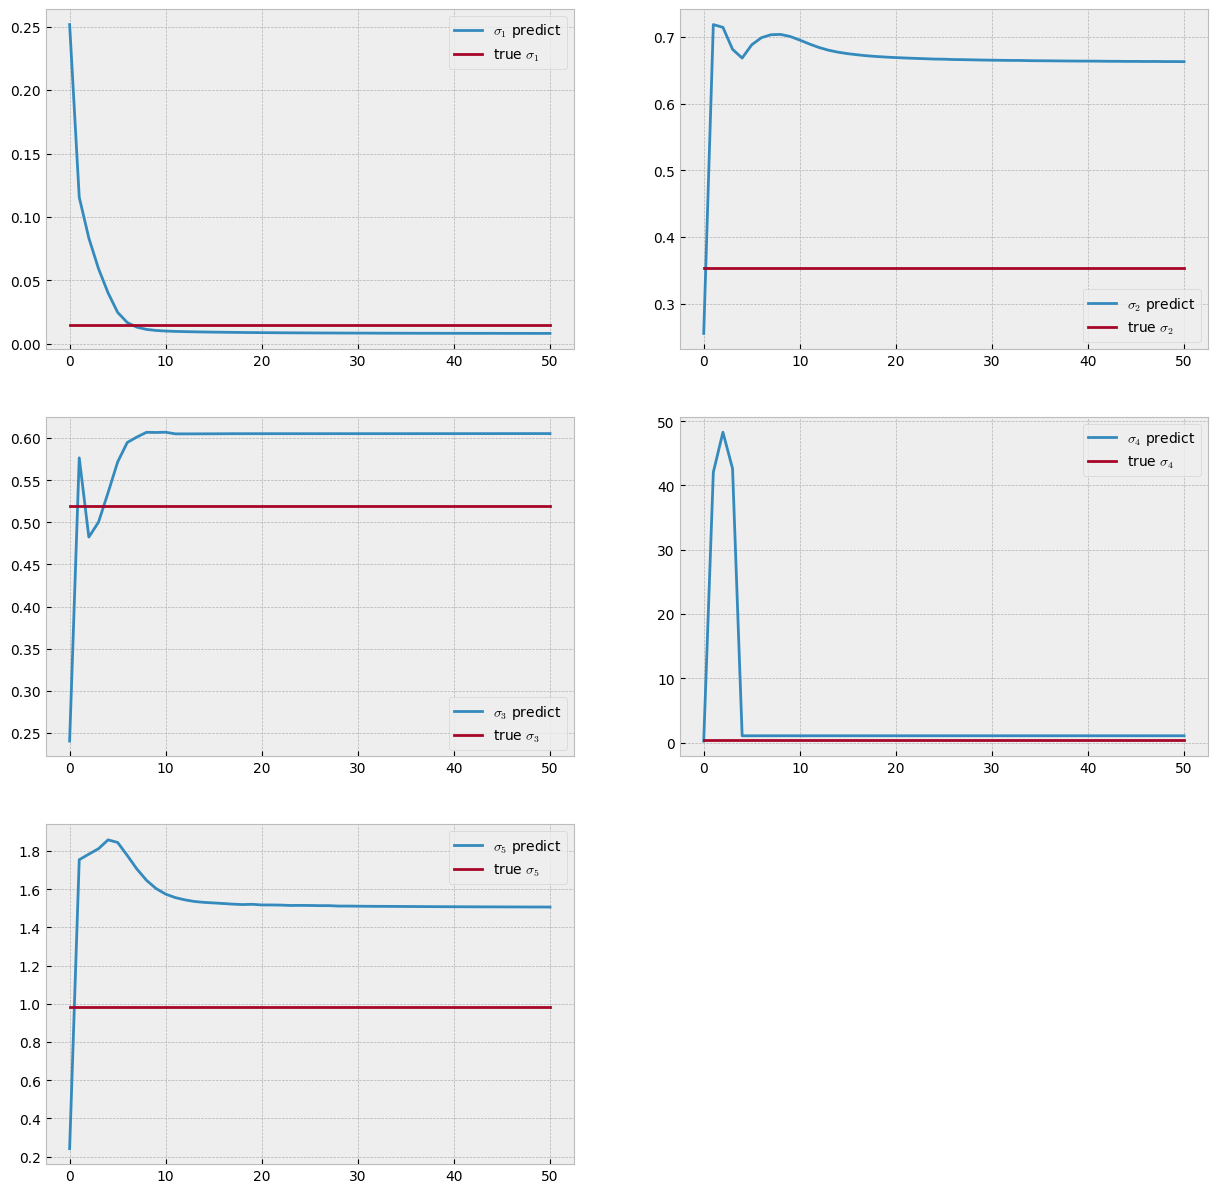

In [17]:
plt.figure(figsize=(15, int(np.ceil(M/2)) * 5))
for i in range(1, M + 1):
    plt.subplot(int(np.ceil(M/2)), 2, i)
    plt.plot(Sigma_estim[:, i - 1]**2, label=f"$\sigma_{i}$ predict")
    plt.plot(Sigma[i-1]*np.ones(len(Sigma_estim[:, i - 1])),label=f"true $\sigma_{i}$")
    plt.legend()
plt.show()

In [18]:
m0_estim_norms = []
for epoch_history in history[1:]:
    m0_estim_norms.append(np.linalg.norm(epoch_history["m0"]))

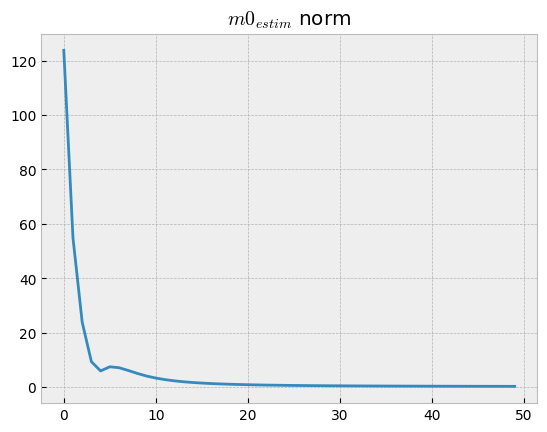

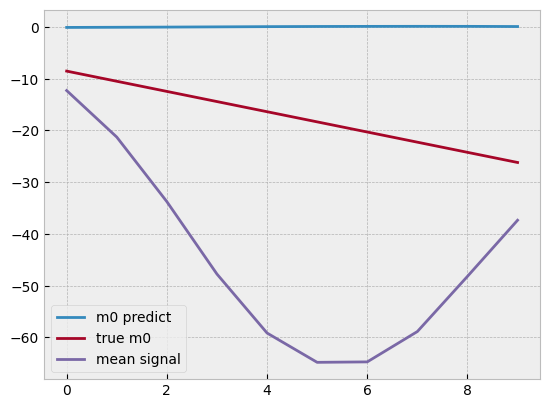

In [19]:
plt.plot(m0_estim_norms)
plt.title("$m0_{estim}$ norm")
plt.show()
plt.plot(history[-1]["m0"],label="m0 predict")
plt.plot(m0,label = "true m0")
plt.plot(Y.mean(axis=0),label = "mean signal")
plt.legend()
plt.show()

In [20]:
theta0_estim = []
for epoch_history in history:
    theta0_estim.append(epoch_history["theta0"])
theta0_estim = np.array(theta0_estim)
print(model.theta0)
print(theta0)

[0.96190157 2.7607597 ]
[32.3326229   5.40349203]


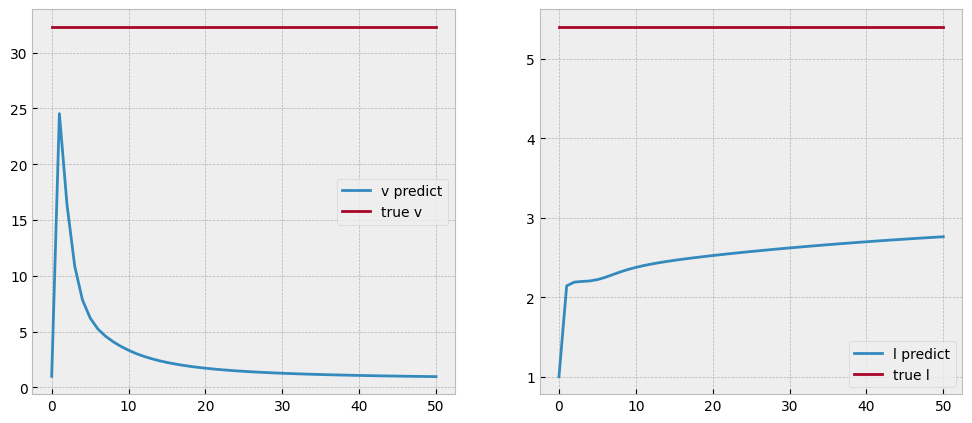

In [21]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(theta0_estim[:, 0], label="v predict")
plt.plot(theta0[0]*np.ones(len(theta0_estim[:, 0])), label="true v")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(theta0_estim[:, 1], label="l predict")
plt.plot(theta0[1]*np.ones(len(theta0_estim[:, 0])), label="true l")
plt.legend()
plt.show()

In [22]:
Theta_estim = []
for epoch_history in history:
    Theta_estim.append(epoch_history["Theta"])
Theta_estim = np.array(Theta_estim)
print(Theta.shape)
print(model.Theta)
print(Theta)

(5, 2)
[[ 65.95455869   4.78826868]
 [ 11.7518969    3.18978532]
 [151.37545194   4.3257124 ]
 [105.39740134   4.04912413]
 [ 69.91205052   6.454127  ]]
[[ 80.47809024   5.07545023]
 [ 21.04363314   5.1463533 ]
 [138.17891266   4.18082566]
 [ 67.03348316   3.62863719]
 [ 91.28344366   6.32655399]]


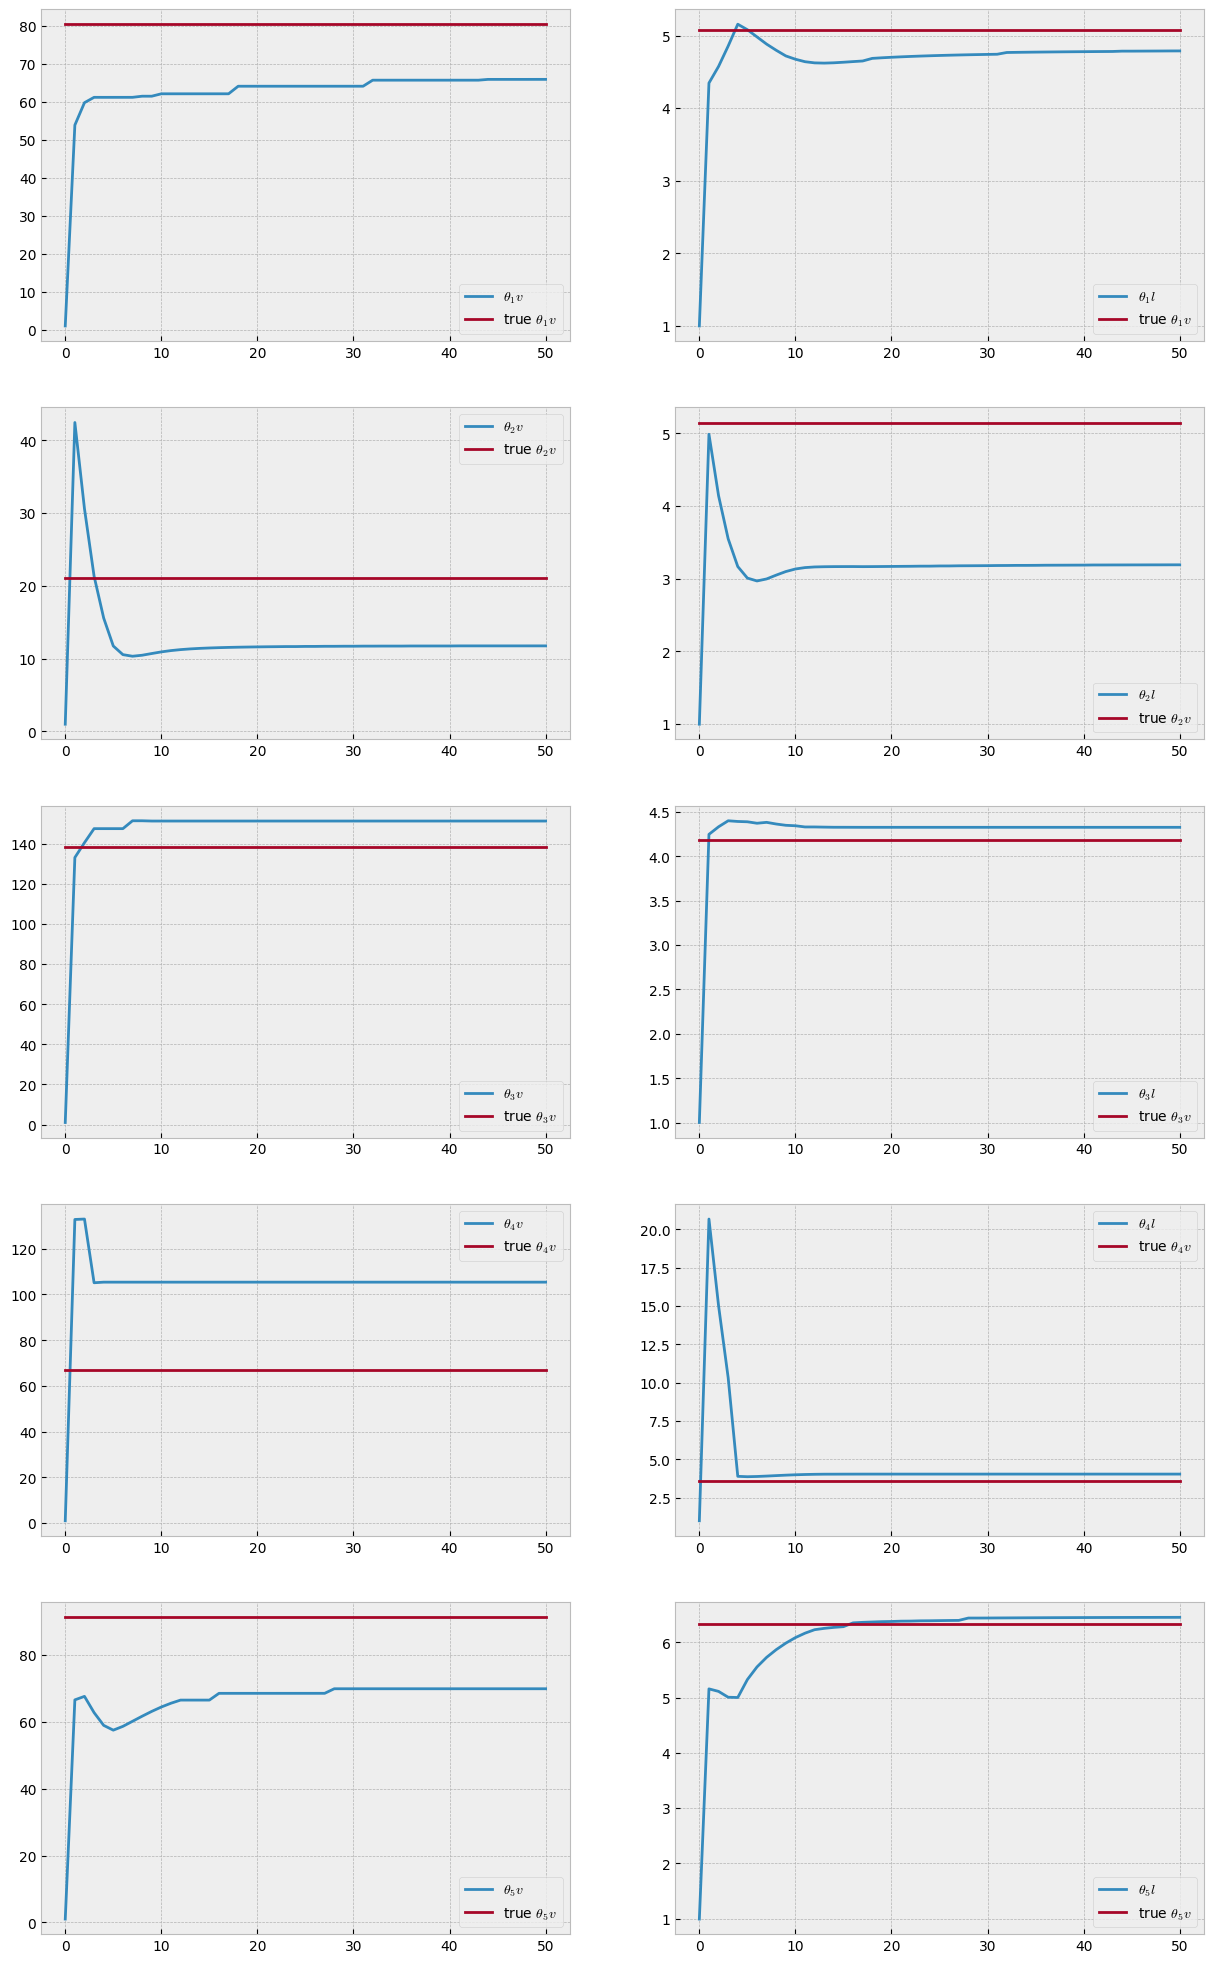

In [23]:
plt.figure(figsize=(15, M * 5))
cpt = 0
for i in range(1, M + 1):
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 0], label=f"$\\theta_{i} v$")
    plt.plot(Theta[i-1,0]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
    cpt += 1
    plt.subplot(M, 2, cpt)
    plt.plot(Theta_estim[:, i - 1, 1], label=f"$\\theta_{i} l$")
    plt.plot(Theta[i-1,1]*np.ones(len(theta0_estim[:, 0])), label=f"true $\\theta_{i} v$")
    plt.legend()
plt.show()

#### Prediction

#### Type II

In [24]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
tObs = 0
T_p_obs = np.linspace(tObs, t0-1e-3, 2*N)
m_p_obs = m0_function(T_p_obs)
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

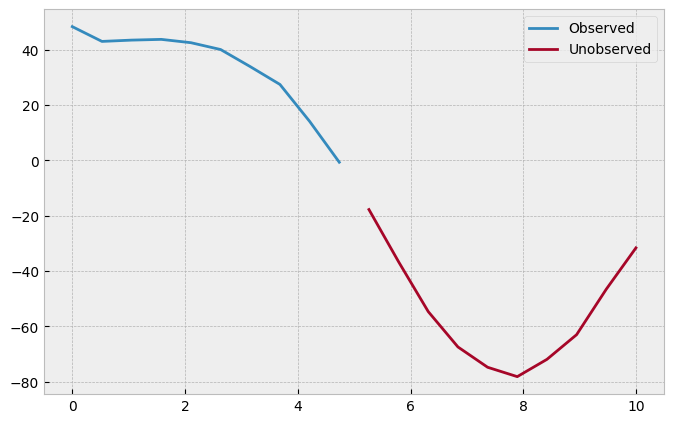

In [25]:
plt.figure(figsize=(8, 5))
plt.plot(T_obs, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [26]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_p, Y_p)

In [27]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

570.5311367464566

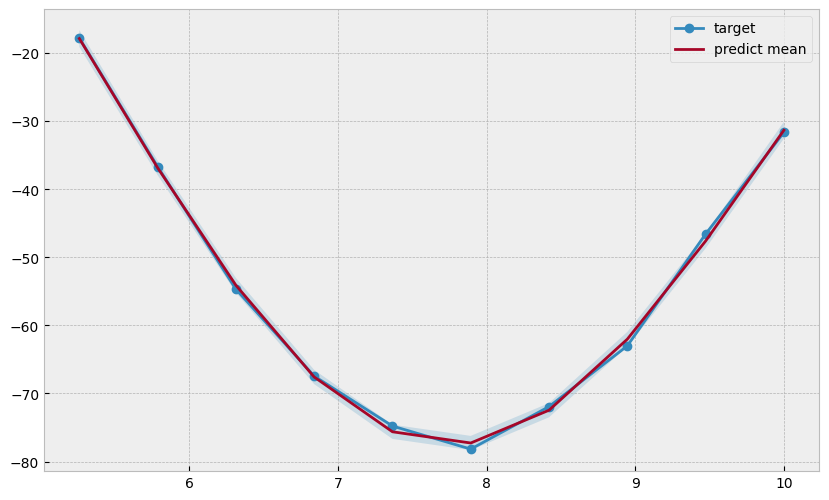

In [28]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

In [29]:
m_P_predict, Cov_P_predict = model.predict(T_p, T_obs, Y_obs)

In [30]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

341.10831056318193

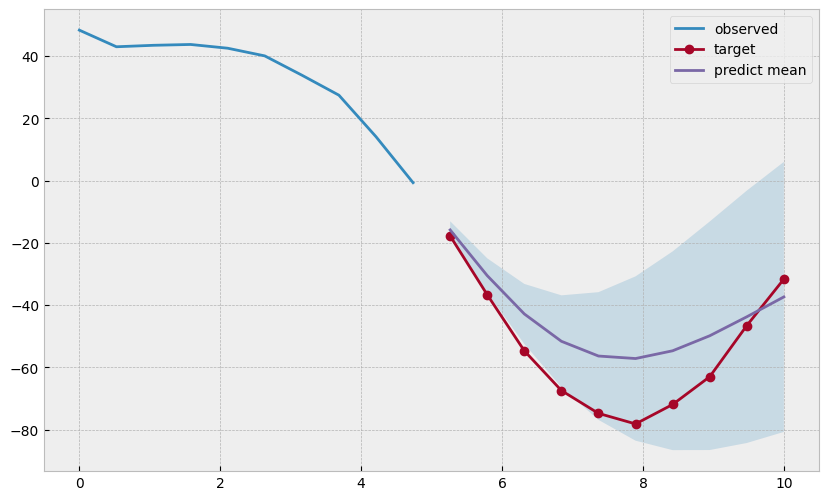

In [31]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()

#### Type I

In [32]:
theta = np.array([np.random.uniform(1, np.exp(5)), np.random.uniform(1, np.exp(2))]).T
sigma = np.random.uniform(0, 1)
m_p_obs = m0_function(T_p_obs)
T_p_obs = np.concatenate([common_T, np.linspace(tN+1e-3, tN + 10, N)])
Cov_p_obs = ExponentiatedQuadraticKernel.compute_all(theta, T_p_obs) + sigma * np.identity(2 * N)
Y_p_obs = np.random.multivariate_normal(m_p_obs, Cov_p_obs)
T_obs = T_p_obs[:N]
T_p = T_p_obs[N:]
Y_obs = Y_p_obs[:N]
Y_p = Y_p_obs[N:]
m_P = m_p_obs[N:]

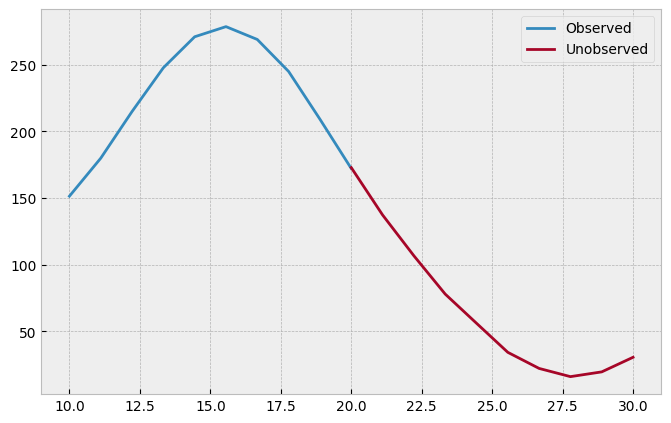

In [33]:
plt.figure(figsize=(8, 5))
plt.plot(common_T, Y_obs, label="Observed")
plt.plot(T_p, Y_p, label="Unobserved")
plt.legend()
plt.show()

In [34]:
m_P_predict, Cov_P_predict = model.predict(T_p, common_T, Y_obs)

In [35]:
((m_P_predict - m_P) ** 2).sum()/(N * M)

2862.5455184439284

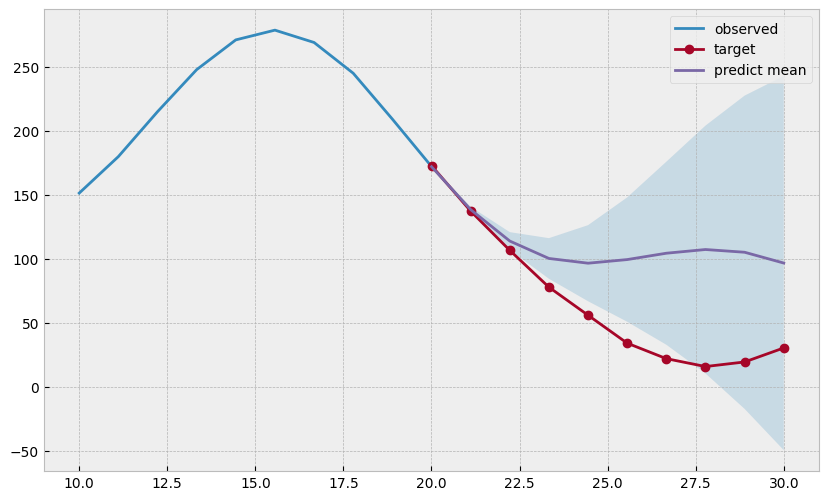

In [36]:
std_dev = np.sqrt(np.diag(Cov_P_predict))
plt.figure(figsize=(10, 6))
plt.plot(T_obs, Y_obs, label="observed")
plt.plot(T_p, Y_p, label='target', marker='o')
plt.plot(T_p, m_P_predict, label='predict mean')
plt.fill_between(T_p, m_P_predict - std_dev, m_P_predict + std_dev, alpha=0.2)
plt.legend()
plt.show()